# Tensorflow core Learning Algorithms

#### .Linear Algorithms
#### .Classifications
#### .Clustering
#### .Hidden Markov Models

# Linear Regression
It is one of the most basic forms of machine learning and is used to predict numeric values. 
It follows a very simple concept. If data points are related linearly we can generate a line of best fit for these points and use it to predict the values.

(0.0, 6.0, 0.0, 20.0)

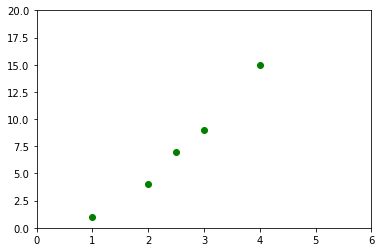

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x=[1, 2, 2.5, 3, 4]
y=[1, 4, 7, 9, 15]

plt.plot(x, y, 'go')
plt.axis([0,6,0,20])

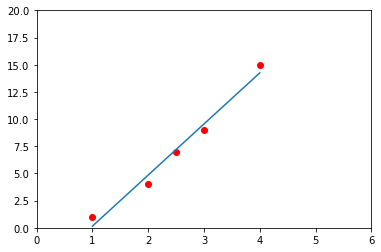

In [4]:
plt.plot(x, y, 'ro')
plt.axis([0,6,0,20])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.show()

### Setup and Imports

In [6]:
pip install -q sklearn

Note: you may need to restart the kernel to use updated packages.


In [8]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

### Data

In [10]:
#Load dataset
X_train=pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') #training dataset
X_test=pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') #testing dataset
y_train=X_train.pop('survived')
y_test=X_test.pop('survived')
print(X_train.iloc[0], y_train.iloc[0])

sex                          male
age                            22
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object 0


In [12]:
X_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [14]:
X_train.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


#### Visuals are always valuable let's generate a few graphs of the data

<AxesSubplot:>

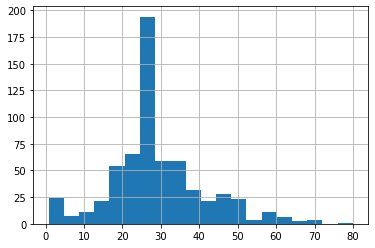

In [16]:
X_train.age.hist(bins=20)

<AxesSubplot:>

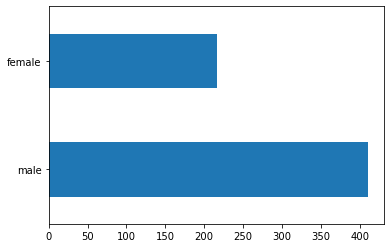

In [18]:
X_train.sex.value_counts().plot(kind='barh')

<AxesSubplot:>

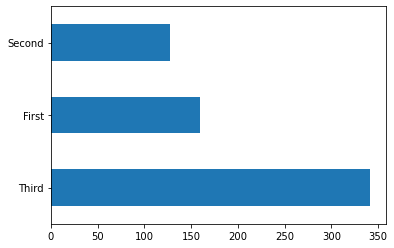

In [20]:
X_train['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

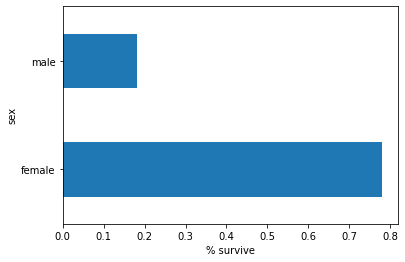

In [22]:
pd.concat([X_train, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

### Training vs Testing Data

#### -->Training data is what we feed to the model so that develop and learn.It is usually a much larger size than the testing data
#### -->Testing data is what we use to evaluate the model and see how well it is performing. We must use a seperate set of data that the model has not been trained on and evaluate it.

In [24]:
X_train.shape

(627, 9)

### The Training Process

#### An epoch is simply one stream of our entire dataset.The numbers of epochs we define is the amount of times our model will see the entire dataset. We use multiple epochs in hope that after seeing the same data multiple times the model will better determine how to estimate it.
#### Since we need to feed our data in batches and multiple tiomes we need to create something called input function. The input function simply defines how our dataset will be converted into batches at each epoch.

### Input Function

#### The Tensorflow model we are going to use requires that data we pass it comes in as tf.data.Dataset object. This means we must create a input function that can convert our current pandas dataFrame into that object.

In [26]:
X_train=pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
X_test=pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') #testing data

y_train=X_train.pop('survived')
y_test=X_test.pop('survived')

CATEGORIAL_COLUMNS=['sex', 'n_siblings_spouses', 'parch',  'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS=['age', 'fare']

feature_columns=[]
for feature_name in CATEGORIAL_COLUMNS:
    vocabulary=X_train[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [28]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds=tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds=ds.shuffle(1000)
        ds=ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn=make_input_fn(X_train, y_train)
test_input_fn=make_input_fn(X_test, y_test, num_epochs=1, shuffle=False)

linear_est=tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\venka\\AppData\\Local\\Temp\\tmpx_n5aafd', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training the model

In [30]:
linear_est.train(train_input_fn)
result=linear_est.evaluate(eval_input_fn)

clear_output()
print(result['accuracy'])

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\venka\AppData\Local\Temp\tmpx_n5aafd\model.ckpt-200
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...
INFO:tensorflow:Savin

NameError: name 'eval_input_fn' is not defined

# Classifications

#### Classification is used to seperate data points into classes of different labels. 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import pandas as pd

### Dataset

#### The species dataset seperates flowers into 3 different classes of species:
##### -->Setosa
##### -->Versicolor
##### -->Virginica

#### The information about each flower is the following:
##### -->Sepal Length
##### -->Sepal Width
##### -->Petal Length
##### -->Petal Width

In [33]:
CSV_COLUMN_NAMES=['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES=['Setosa', 'Versicolor', 'Virginica']

In [34]:
train_path=tf.keras.utils.get_file('iris_training.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv')
test_path=tf.keras.utils.get_file('iris_test.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv')

train=pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test=pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)

In [35]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [14]:
test.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,5.9,3.0,4.2,1.5,1
1,6.9,3.1,5.4,2.1,2
2,5.1,3.3,1.7,0.5,0
3,6.0,3.4,4.5,1.6,1
4,5.5,2.5,4.0,1.3,1


In [47]:
train_y=train.iloc[-1]
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [48]:
train.shape

(120, 4)

### Input Function

In [36]:
def input_fn(features, label, training=True, batch_size=256):
    dataset=tf.data.Dataset.from_tensor_slices((dict(features), label))

    if training:
        dataset=dataset.shuffle(1000).repeat()

    return dataset.batch(batch_size)

### Feature Columns

In [37]:
my_feature_columns=[]
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Species', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


### Building the model

#### And now we are ready to choose a model.For classification tasks there are varietyu of different estimators/models that we can pick from. Some options are:

#### -->DNN Classifier(Deep Neural Network)
#### -->LinearClassifier

In [38]:
classifier=tf.estimator.DNNClassifier(feature_columns=my_feature_columns, hidden_units=[30, 10], n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\venka\\AppData\\Local\\Temp\\tmp30m7r4j4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training

In [ ]:
classifier.train(input_fn=lambda: input_fn(train, train_y, training=True), steps=5000)

#We included lambda to avoid creating an inner function previously